## import libraries 

In [1]:
import pandas
import configparser
import psycopg2

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['myaws']['host']
db = config['myaws']['db']
user = config['myaws']['user']
pwd = config['myaws']['pwd']

In [3]:
conn = psycopg2.connect(host = host,
                       user = user,
                        password = pwd,
                        dbname = db
                       )
cur = conn.cursor()

## create the hosue table

make sure change the schema name to your gp number

In [5]:


# replace the schema and table name to your schema and table name
table_sql = """
            CREATE TABLE IF NOT EXISTS gp9.house
            (

                price integer,
                bed integer,
                bath integer,
                area integer,
                address VARCHAR(200),
                PRIMARY KEY(address)
            );

            """



use the bellow cell only if you want to delete the table

In [117]:
#conn.rollback()
#table_sql="drop table if exists demo.house"

In [6]:

cur.execute(table_sql)
conn.commit()

## define the search region

In [7]:
url = 'https://www.trulia.com/VA/Ashburn/20147/'

In [9]:


import urllib.request
response = urllib.request.urlopen(url)
html_data= response.read()
print(html_data.decode('utf-8'))



<!DOCTYPE html><html lang="en"><head><meta charSet="utf-8"/><script>
            window.__uspapi = function(command, version, callback) {
              try {
                if (command === 'getUSPData') {
                  var cookies = document.cookie.split(';');
                  for (var i = 0; i < cookies.length; i++) {
                    var cookie = cookies[i];
                    var separatorIndex = cookie.indexOf('=');
                    separatorIndex = separatorIndex < 0 ? cookie.length : separatorIndex;
                    var cookie_name = decodeURIComponent(cookie.slice(0, separatorIndex).replace(/^\s+/, ''));
                    if (cookie_name === 'usprivacy') {
                      var uspString = decodeURIComponent(cookie.slice(separatorIndex + 1));
                      callback({ version: version, uspString: uspString }, true);
                      return;
                    }
                  }
                }
              } catch (ex) {
                c

In [10]:


from bs4 import BeautifulSoup
soup = BeautifulSoup(html_data,'html.parser')
# print (soup)



## insert the records into database

In [11]:

for li_class in soup.find_all('li', class_ = 'Grid__CellBox-sc-144isrp-0 SearchResultsList__WideCell-b7y9ki-2 jiZmPM'):
    try:
        for price_div in li_class.find_all('div',{'data-testid':'property-price'}):
            price =int(price_div.text.replace('$','').replace(",",""))
        for bed_div in li_class.find_all('div', {'data-testid':'property-beds'}):
            bed= int(bed_div.text.replace('bd','').replace(",",""))
        for bath_div in li_class.find_all('div',{'data-testid':'property-baths'}):
            bath =int(bath_div.text.replace('ba','').replace(",",""))
        for area_div in li_class.find_all('div',{'data-testid':'property-floorSpace'}):
            area=int(area_div.text.split('sqft')[0].replace(",",""))
        for address_div in li_class.find_all('div',{'data-testid':'property-address'}):
            address =address_div.text

        try:
            sql_insert = """
                        insert into gp9.house(price,bed,bath,area,address)
                        values('{}','{}','{}','{}','{}')            
                        """.format(price,bed,bath,area,address)

            cur.execute(sql_insert)
            conn.commit()
        except:
            conn.rollback()
    except:
        pass
        

## Query the Table

In [12]:
df = pandas.read_sql_query('select * from gp9.house ', conn)
df[:10]

,price,bed,bath,area,address
0,795000,4,4,3570,"20254 Ordinary Pl, Ashburn, VA 20147"
1,449900,2,3,1648,"44263 Litchfield Ter, Ashburn, VA 20147"
2,499900,3,4,1836,"43777 Stubble Corner Sq, Ashburn, VA 20147"
3,489990,4,4,2102,"19932 Fieldgrass Sq, Ashburn, VA 20147"
4,349000,2,3,1394,"45051 Brae Ter #102, Ashburn, VA 20147"
5,839000,4,4,3927,"20412 Peckham St, Ashburn, VA 20147"
6,389900,2,2,1359,"21025 Rocky Knoll Sq #105, Ashburn, VA 20147"
7,349900,3,3,1284,"43840 Hickory Corner Ter #108, Ashburn, VA 20147"
8,499990,3,4,1740,"43781 Stubble Corner Sq, Ashburn, VA 20147"
9,670000,4,4,3292,"20066 Valhalla Sq, Ashburn, VA 20147"


## basic stat

In [13]:
df.describe()

,price,bed,bath,area
count,3.300000e+01,33.000000,33.000000,33.000000
mean,6.563372e+05,3.151515,3.333333,2572.090909
std,3.292109e+05,1.034445,0.957427,1512.418435
min,2.399000e+05,1.000000,1.000000,747.000000
25%,4.899900e+05,2.000000,3.000000,1474.000000
50%,5.999000e+05,3.000000,4.000000,2000.000000
75%,6.700000e+05,4.000000,4.000000,3000.000000
max,1.640000e+06,5.000000,5.000000,6611.000000


## price distribution

<AxesSubplot:>

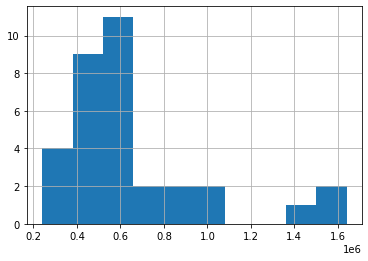

In [14]:
df['price'].hist()

## bed vs bath

<AxesSubplot:xlabel='bed', ylabel='bath'>

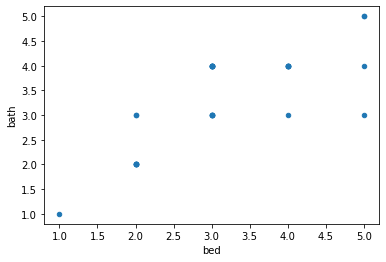

In [15]:
df.plot.scatter(x='bed',y='bath')